<a href="https://colab.research.google.com/github/tjebbel/dotfiles/blob/master/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

🎯 **Exercise objectives**
- Discover ***autoencoders***
- Get a deeper understanding of CNNs

<hr>

👉 There exists a very particular architecture in Deep Learning called **`Autoencoders`**. Autoencoders are Neural Network architectures trained to return **outputs that are as similar as possible to the original inputs fed to them**. Why would we do that?  

Before answering the question _"why"_, let's answer the question _"how"_.

👩🏻‍🏫 <u>***How does an autoencoder work ?***</u>

There are two parts in an autoencoder: the  **`encoder`** and the **`decoder`**.

1. In the encoder, we will make the information flow through different dense layers with a decreasing number of neurons. It will create a **`bottleneck`** where the information is compressed.

2. In the decoder, we will try to recreate the original data based on the compressed data.

🔥 <u>***Why is it powerful or useful?***</u>

If it works well, it means two important things:

* ✅ We can afford to **compress our dataset** and use a compressed version of it when fitting another Neural Network! 

* ✅ The **information contained in the bottleneck** - i.e. the data compressed in a low-dimensional layer - **accurately captures the patterns of our dataset** and the autoencoder is able to decode the compressed information!

🌠 <u>**Applications:**</u>
- Image compression
- Denoising (cf. Google Pixel phones...)
- Image generation!


<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

## (0) The MNIST Dataset

In this notebook, we will train an auto-encoder to work on 28x28 grey images from the MNIST dataset, available in Keras. Run the cells below

In [2]:
from tensorflow.keras.datasets import mnist

(images_train, labels_train), (images_test, labels_test) = mnist.load_data()
print(images_train.shape)
print(images_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [3]:
# Add a channels for the colors and normalize data
X_train = images_train.reshape((60000, 28, 28, 1)) / 255.
X_test = images_test.reshape((10000, 28, 28, 1)) / 255.

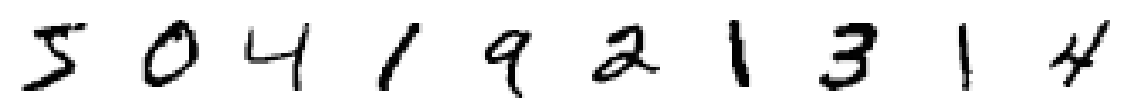

In [4]:
# Plot some images
import matplotlib.pyplot as plt

f, axs = plt.subplots(1, 10, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.axis('off')
    ax.imshow(X_train[i].reshape(28, 28), cmap='Greys')
    
plt.show()

## (1) The encoder

🎁 First, we built the "Encoder" part for you.

👉  Notice how similar it looks compared to a Convolutional Classifier with **latent_dimension** neurons at the end. However, we using the "tanh" activation function in the final dense layer instead of "relu".

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_encoder(latent_dimension):
    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()
    
    encoder.add(Conv2D(8, (2,2), input_shape=(28, 28, 1), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(16, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(32, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))     

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))
    
    return encoder

❓ **Question: building an encoder** ❓ 

Build your encoder with **`latent_dimension = 2`** and look at the number of parameters.

In [6]:
encoder = build_encoder(2)
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 8)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 32)         0

## (2) Decoder

It's your turn to build the decoder this time!

We need to build a 🔥 **`reversed CNN` 🔥** that 
* takes a dense layer as input,
* and outputs an image of shape $ (28,28,1) $ similar to our MNIST images. 

📚 For this purpose, we will use a new layer called <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">**`Conv2DTranspose`**</a> 📚
    
The name of this layer speaks for itself: it performs the opposite of a convolution operation!

💡 We will follow this strategy:
* Start by reshaping the Dense Input Layer into an Image of shape $(7,7,..)$
* Then apply the `Conv2DTranspose` operation with ***strides = 2*** to double the output shape to $(14,14,..)$
* then add another Conv2DTranpose layer on top of the first one to make it $(28,28,1)$.

<hr>

❓ **Question: the architecture of a decoder** ❓ 


Define a **`decoding architecture`** in the method below as follows:
- a *Dense* layer with:
    - $7 \times 7 \times 8$ neurons, 
    - *input_shape* = (latent_dimension, )
    - *tanh* activation function. 
- a *Reshape* layer that reshapes to $(7, 7, 8)$ tensors
- a *Conv2DTranspose* with:
    - $8$ filters, 
    - $(2,2)$ kernels, 
    - strides of $2$, 
    - padding *same* 
    - _relu_ activation function
- a second Conv2DTranspose layer with:
    - $1$ filter,
    - $(2,2)$ kernels,
    - strides of $2$,
    - padding _same_,
    - _relu_ activation function

In [7]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose

def build_decoder(latent_dimension):
  decoder = Sequential()
  decoder.add(Dense(7*7*8, activation='tanh', input_shape=(latent_dimension,)))
  decoder.add(Reshape((7, 7, 8)))  # no batch axis here
  decoder.add(Conv2DTranspose(8, (2, 2), strides=2, padding='same', activation='relu'))

  decoder.add(Conv2DTranspose(1, (2, 2), strides=2, padding='same', activation='relu'))
  return decoder

❓ **Question: buiding a decoder** ❓ 

Build your decoder with **`latent_dimension = 2`** and check that it outputs images of same shape than the encoder input

In [8]:
decoder = build_decoder(2)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 392)               1176      
                                                                 
 reshape (Reshape)           (None, 7, 7, 8)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        264       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 1)        33        
 ranspose)                                                       
                                                                 
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________


## (3) Auto-Encoder

🎉 We can now **concatenate** both **`the encoder and the decoder`** thanks to the **`Model`** class in Keras, using the **`Functional API`**.

In [9]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

def build_autoencoder(encoder, decoder):
    inp = Input((28, 28,1))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

❓ **Questions** ❓ 

* Try to understand syntax above 👆 
* Build your autoencoder
* Have a look at the number of parameters

In [10]:
autoencoder = build_autoencoder(encoder, decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 2)                 2906      
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         1473      
                                                                 
Total params: 4,379
Trainable params: 4,379
Non-trainable params: 0
_________________________________________________________________


❓ **Question: Compiling an autoencoder** ❓ 

Define a method which compiles your model. Pick an appropriate loss.

<u><i>Think carefully:</i></u> 🤔 On which mathematical object are we going to compare *predictions* and the *ground truth* for the computation of the loss function and the metrics?


<details>
    <summary><i>Answer</i></summary>

It should compare two images (Black and White in our case), pixel-by-pixel!
    
The MSE loss seems to be an appropriate loss function for pixel-by-pixel error minimization.
</details>

In [11]:
def compile_autoencoder(autoencoder):
    autoencoder.compile(loss='mse',
                  optimizer='adam')

In [12]:
compile_autoencoder(autoencoder)
autoencoder.fit(X_train, X_train, epochs = 20, batch_size = 32)

Epoch 1/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0600
Epoch 2/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0534
Epoch 3/20
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0526
Epoch 4/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0522
Epoch 5/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0520
Epoch 6/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0518
Epoch 7/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0517
Epoch 8/20
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0516
Epoch 9/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0514
Epoch 10/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0513
Epoch 11/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0512
Epoch 12/20
1875/1875 [==============================] - 31s 17

❓ **Question: Training an autoencoder** ❓  

* Compile your model and fit it with `batch_size = 32` and `epochs = 20`. 
* What is the label `y_train` in this case?

<i>Note:</i> Don't waste your time fighting overfitting in this challenge, you will have time to care about this during the project weeks :)

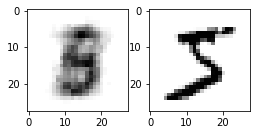

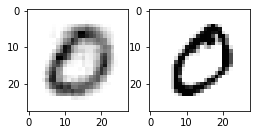

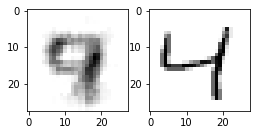

In [13]:
prediction = autoencoder.predict(X_train, verbose=0, batch_size=100)# you can now display an image to see it is reconstructed well

for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    ax1.imshow(prediction[i].reshape(28,28), cmap = 'Greys')
    ax2.imshow(X_train[i].reshape(28,28), cmap = 'Greys')
    plt.show()

❓ **Question: Encoding the dataset** ❓

* Using only the encoder part of the network, encode your dataset and save it under `X_encoded` . 
    * Each image is now represented by two values (that correspond to the dimension of the latent space, of the bottleneck; aka the `latent_dimension`. 

In [14]:
X_encoded = encoder.predict(X_train, verbose=1)

1875/1875 [==============================] - 10s 6ms/step


🤔 Where are we after running the encoder?

* Each image was compressed into a 2D space. 
* Each of these handwritten digit have a given label, between 0 and 9, but the goal here is not to classify these pictures like in the first challenge but to **reconstruct the original image before the compression**.

❓ **Question: Visualizing handwritten digits in the latent space** ❓ 

Scatterplot the encoded data (only a small fraction of the encoded dataset for visibility purposes...)
- Each point of the scatter plot  corresponds to an encoded image
- Color the dots according to their respective labels (digit representation):
    - for instance, all the "4"s should be represented by a color on this scatter plot...
    - ...while the "5" should be represented by another color
    - choose a set of [`qualitative colormaps`](https://matplotlib.org/stable/gallery/color/colormap_reference.html)

What do you remark about this plot? 

In [15]:
labels_train[:300]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2,
       9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4,
       5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6, 1, 9,
       9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5,
       9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8,
       3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5,
       2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6,
       3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7,
       9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9,
       6, 5, 7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3, 6], d

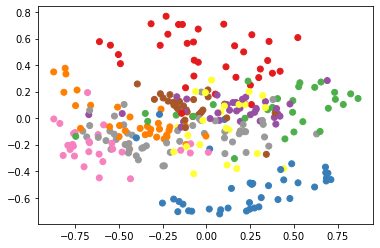

In [16]:
import seaborn as sns
plt.scatter(x = X_encoded[:300, 0], 
            y = X_encoded[:300, 1], 
            c = labels_train[:300], 
            cmap = 'Set1');

## (4) Application: Image denoising

❓ **Questions: Creating some noise in the dataset** ❓ 

* Let's add some noise to the input data. 
* Run the following code
* Plot some handwritten digits and their noisy versions

In [17]:
import numpy as np

noise_factor = 0.5

X_train_noisy = X_train + noise_factor * np.random.normal(0., 1., size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(0., 1., size=X_test.shape)

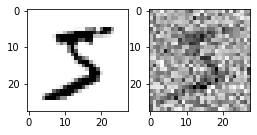

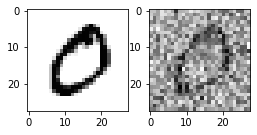

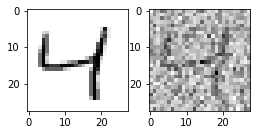

In [18]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    ax1.imshow(X_train[i].reshape(28,28), cmap='Greys')
    ax2.imshow(X_train_noisy[i].reshape(28,28), cmap='Greys')
    plt.show()

In [19]:
encoder = build_encoder(2)
decoder = build_decoder(2)
autoencoder = build_autoencoder(encoder, decoder)
compile_autoencoder(autoencoder)

history_denoising = autoencoder.fit(X_train_noisy, X_train, 
                                    epochs = 20, 
                                    batch_size=32)

Epoch 1/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0616
Epoch 2/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0554
Epoch 3/20
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0542
Epoch 4/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0536
Epoch 5/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0533
Epoch 6/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0530
Epoch 7/20
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0528
Epoch 8/20
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0527
Epoch 9/20
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0525
Epoch 10/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0524
Epoch 11/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0523
Epoch 12/20
1875/1875 [==============================] - 32s 17

313/313 [==============================] - 2s 7ms/step


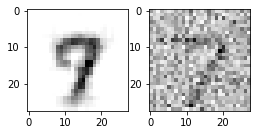

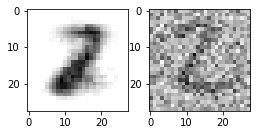

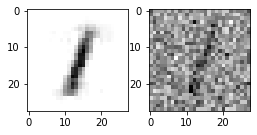

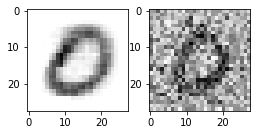

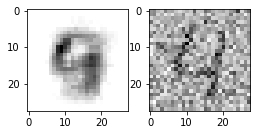

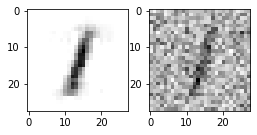

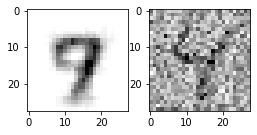

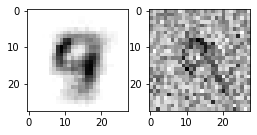

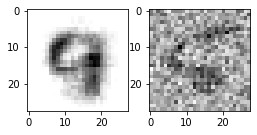

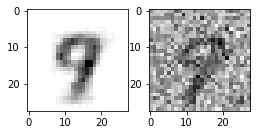

In [20]:
prediction = autoencoder.predict(X_test_noisy, verbose=1)

for i in range(10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    ax1.imshow(prediction[i].reshape(28,28), cmap='Greys')
    ax2.imshow(X_test_noisy[i].reshape(28,28), cmap='Greys')
    plt.show()

❓ **Question: decoding the noisy pictures** ❓ 

* Reinitialize your autoencoder (with a latent space of 2) 
* Train it again, this time using the noisy train dataset instead of the normal train dataset
    * *Keep `batch_size = 32` and `epochs = 5`*
* What do you expect if you run the autoencoder on the noisy data instead of the original data in terms of performance?

❓ **Question: comparing the noisy test images with the denoised images** ❓ 

For some noisy test images, predict the denoised images and plot the results side by side...

❓ **Question: choosing the "correct" latent_dimension** ❓ 

Now, try to evaluate which **`latent_dimension`** is the most suitable in order to have **`the best image reconstruction preprocess`** $ \Leftrightarrow $ How to remove as much noise as possible in the noisy dataset using the latent dimension?`

In [21]:
latent_dimensions = list(range(2,20,3))

test_errors = []
for latent_dimension in latent_dimensions:
    print(" ")
    print("-"*80)
    print(f"Running the autoencoder with latent_dimension = {latent_dimension}")
    print("-"*80)    
    encoder = build_encoder(latent_dimension=latent_dimension)
    decoder = build_decoder(latent_dimension=latent_dimension)
    autoencoder = build_autoencoder(encoder, decoder)
    compile_autoencoder(autoencoder)
    autoencoder.fit(X_train, X_train, epochs=20, batch_size=32)
    error = autoencoder.evaluate(X_test, X_test)
    test_errors.append(error)


 
--------------------------------------------------------------------------------
Running the autoencoder with latent_dimension = 2
--------------------------------------------------------------------------------
Epoch 1/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0596
Epoch 2/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0538
Epoch 3/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0528
Epoch 4/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0524
Epoch 5/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0521
Epoch 6/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0518
Epoch 7/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0517
Epoch 8/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0515
Epoch 9/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0514
Epoch 10/20
1875/1875

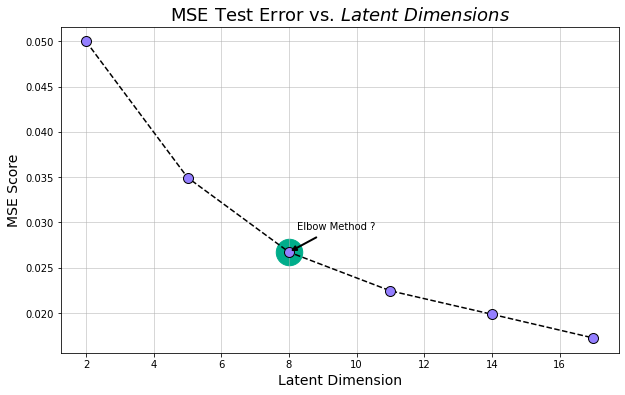

In [22]:
import matplotlib.pyplot as plt

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(latent_dimensions, 
            test_errors,
            color='black', 
            linestyle='dashed', 
            marker='o',
            markerfacecolor='#947FFF', 
            markersize=10)
    # more
    ax.set_title('MSE Test Error vs. $Latent$ $Dimensions$', fontsize = 18)
    ax.set_xlabel('Latent Dimension', fontsize = 14)
    ax.set_ylabel('MSE Score', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    
    # focusing
    ax.scatter(8,test_errors[2],c='#00ad8b',s=700)
    
    # annotate
    ax.annotate("Elbow Method ?", 
               xy=(8,test_errors[2]),
                xytext=(8+0.25,test_errors[2]+0.0025), 
                arrowprops=dict(arrowstyle='-|>',
                                fc="k",
                                ec="k",
                                lw=2),
                bbox=dict(pad=5, facecolor="none", edgecolor="none")
               ) 
    
    
    plt.show();


🥡 <b><u>Conclusion</u></b>


* It is obvious that:
    * if you compress your pictures of size $ 28 \times 28 $ into a 1D space, you will lose a ton of information. 
    * if you compress them into a $ 28 \times 28 = 784$ -space, you are actually not compressing them
    
* We can still use this graph of **Loss vs. Latent dimensions** reading it from right to left to decide in which latent space it would be advisable to compress the pictures without losing to much information: `latent_space = 8` seems a sweat spot here using the Elbow Method.

---

🏁 **Congratulations** 🏁 

1. Download this notebook from your `Google Drive` or directly from `Google Colab` 
2. Drag-and-drop it from your `Downloads` folder to your local `[GITHUB_USERNAME]/data-challenges/06-Deep-Learning/03-Convolutional-Neural-Networks/05-autoencoders`


💾 Don't forget to push your code

3. Follow the usual procedure on your terminal in the `06-Deep-Learning/03-Convolutional-Neural-Networks/05-autoencoders` folder:
      * *git add cifar_classification.ipynb*
      * *git commit -m "I am the god of Transfer Learning"*
      * *git push origin master*

*Hint*: To find where this Colab notebook has been saved, click on `File` $\rightarrow$ `Locate in Drive`.

😉 That was the last challenge of this module!